<h3>RNN on Optimal Entry/Exit</h3>
<p>Using RNN on the algorithm that finds entry/exit.</p>

In [1]:
import os
os.chdir('../../')
os.getcwd()

'/Users/rosscopeland/Desktop/personal/code/vivaldi/back_testing'

<p>imports</p>

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from v2.model import Trading
from v2.strategy.indicators.smma import SMMA
from v2.strategy.indicators.stochastic_oscillator import StochasticOscillator
from v2.strategy.indicators.bollinger_bands import BollingerBands
from v2.strategy.indicators.rsi import RSI
from v2.strategy.indicators.macd import MACD
from v2.strategy.indicators.param import Param

In [45]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

<p>Loading the configuration file so that we can get which coins we are testing over and over what period of time we are doing it over</p>

In [12]:
def load_config():
    my_config = {}
    with open('config.config') as config:
        for line in config:
            args = line.split('=')
            my_config[args[0]] = args[1].rstrip().split(',')
    return my_config

model = Trading(load_config())

<p> Here we are modifying the dataset and adding all of the indicators that we implemented. These will be some of the features that we will be using for our Recurrent Neural Network </p>

In [13]:
datasets = model.dfs
appended_dataset = pd.DataFrame()
for d in datasets:
    training_set = d[0]
    training_set['trough'] = training_set.iloc[argrelextrema(training_set.close.values, np.less_equal, order=480)[0]]['close']
    training_set['peak'] = training_set.iloc[argrelextrema(training_set.close.values, np.greater_equal, order=480)[0]]['close']
    ema_fast = Param(5, 10000, 0, 'ema_fast', 60)
    ema_slow= Param(6, 10001, 0, 'ema_slow', 120)
    signal = Param(5, 10001, 0, 'signal', 90)
    macd_ = MACD(_params=[ema_fast, ema_slow, signal], _name='macd')
    macd_.genData(training_set, gen_new_values=False)
    boll_period = Param(5, 10000, 0, 'period', 90)
    boll_bands = BollingerBands(_params=[boll_period], _name='bollinger_bands')
    boll_bands.genData(training_set, gen_new_values=False)
    stoch_highlow = Param(5, 10000, 0, 'highlow_range', 90.0)
    stoch_k = Param(5, 10000, 0, 'k_period', 270.0)
    stoch_oscillator = StochasticOscillator(_params=[stoch_highlow, stoch_k], _name='stochastic_oscillator')
    stoch_oscillator.genData(training_set, gen_new_values=False)
    rsi_period = Param(5, 10000, 0, 'period', 90.0)
    rsi_ = RSI(_params=[rsi_period], _name='rsi')
    rsi_.genData(training_set, gen_new_values=False)
    smma_period = Param(5, 10000, 0, 'period', 90.0)
    smma_ = SMMA(_params=[smma_period], _name='smma')
    smma_.genData(training_set, gen_new_values=False)
    training_set[['trough', 'peak']] = training_set[['trough', 'peak']].fillna(0)
    training_set['slope'] = (training_set['close'].rolling(window=30).max() - training_set['close'].rolling(window=30).min()) / training_set['close'].rolling(window=30).max()
    training_set = training_set.dropna()
    appended_dataset = appended_dataset.append(training_set)

In [58]:
trough_input_data = appended_dataset[['stosc_k', 'slope', 'macd_diff', 'rsi']]
appended_dataset['trough'] = appended_dataset['trough'].gt(0).astype(int)
is_trough = appended_dataset[['trough']]

raw_x_train_df, raw_x_test_df, raw_y_train_df, raw_y_test_df = train_test_split(trough_input_data, is_trough, test_size=0.2, shuffle=False)

classify_all = np.array(trough_input_data)
classify_X_train = np.array(raw_x_train_df)
classify_X_test = np.array(raw_x_test_df)
classify_y_train = np.array(raw_y_train_df)
classify_y_test = np.array(raw_y_test_df)

<p>The random forest model including other ones are used as features within the recurrent neural network</p>

In [59]:
#random forrest
rand_forest = RandomForestClassifier(random_state=69420, max_features=None, criterion='gini', n_estimators=10, n_jobs=-1, min_samples_leaf=1)
rand_forest.fit(classify_X_train, classify_y_train)
#, classify_y_test)

<ipython-input-59-1353e627c18d>:3: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



RandomForestClassifier(max_features=None, n_estimators=10, n_jobs=-1,
                       random_state=69420)

In [60]:
train_pred = rand_forest.predict_proba(np.array(raw_x_train_df))[:,1]
test_pred = rand_forest.predict_proba(np.array(raw_x_test_df))[:,1]

raw_x_train_df["RF_prediction"] = train_pred
raw_x_test_df["RF_prediction"] = test_pred

<ipython-input-60-2e87e6fb2b88>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-60-2e87e6fb2b88>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<p> We are using another model (XGBoost) as a feature within the recurrent neural network </p>

In [61]:
#grad boost
boost_all = np.array(trough_input_data)
boost_X_train = np.array(raw_x_train_df)
boost_X_test = np.array(raw_x_test_df)

boost = XGBClassifier(subsample = 0.7, max_depth = 4)
boost.fit(boost_X_train, classify_y_train)


/usr/local/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.7,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [62]:
boost_train_pred = boost.predict_proba(np.array(raw_x_train_df))[:,1]
boost_test_pred = boost.predict_proba(np.array(raw_x_test_df))[:,1]

raw_x_train_df["boost_prediction"] = boost_train_pred
raw_x_test_df["boost_prediction"] = boost_test_pred

<ipython-input-62-d8a1e6fcdd4f>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-62-d8a1e6fcdd4f>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<p> This is now the data which we will use for testing and training. Before didn't split up because we want to train and test across models which have the same times </p>

In [63]:
# x_train, x_test, y_train, y_test = train_test_split(trough_input_data.values, is_trough.values, test_size=0.2, shuffle=False)
x_train = raw_x_train_df.values
x_test = raw_x_test_df.values
y_train = raw_y_train_df.values
y_test = raw_y_test_df.values

#this is for tensorflow lstm stuff
x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))

x_train.shape

(1160540, 1, 6)

<p> This is where we create the LSTM is relatively simple model. Hopefully we can keep getting better results by tweaking the models </p>

In [64]:
model = Sequential()
model.add(LSTM(128, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(128, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(2, activation='softmax'))

opt = tf.keras.optimizers.Adam(lr=1e-3, decay=1e-5)

model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
num_ones = int(sum(y_train))
zero_weight = num_ones / len(y_train)
one_weight = (len(y_train) - num_ones) / len(y_train)
model_weights = []
for x in y_train:
    if x == 0.0:
        model_weights.append(zero_weight)
    else:
        model_weights.append(one_weight)
model_weights = np.array(model_weights)

In [51]:
model_weights

array([0.00219489, 0.00219489, 0.00219489, ..., 0.00219489, 0.00219489,
       0.00219489])

In [57]:
model.fit(x_train, y_train, epochs=3, sample_weight=model_weights, validation_data=(x_test, y_test))

KeyboardInterrupt: 

<p> Graphing the predictions from the LSTM aggregate model </p>

In [71]:
trading = Trading(load_config())
datasets = trading.dfs
test_data = datasets[0][0]

macd_.genData(test_data, gen_new_values=False)

boll_bands.genData(test_data, gen_new_values=False)

stoch_oscillator.genData(test_data, gen_new_values=False)

rsi_.genData(test_data, gen_new_values=False)
test_data['slope'] = (test_data['close'].rolling(window=10).max() - test_data['close'].rolling(window=10).min()) / test_data['close'].rolling(window=10).max()
test_data = test_data.dropna()

new_input_data_trough = test_data[['stosc_k', 'slope', 'macd_diff', 'rsi']].values
new_input_data_trough = np.reshape(new_input_data_trough, (new_input_data_trough.shape[0], 1, new_input_data_trough.shape[1]))
predictions = model.predict(new_input_data_trough)[:,1]


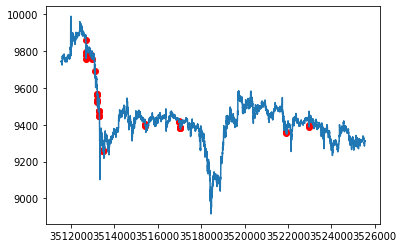

In [73]:

test_data['predictions_trough'] = predictions
def insert_predictions(close, prediction):
    if prediction > 0.95:
        return close
    else:
        return None
test_data['predictions_trough'] = test_data.apply(lambda row: insert_predictions(row['close'], row['predictions_trough']), axis=1)
plt.scatter(test_data.index, test_data['predictions_trough'], c='r')
# axes = plt.gca()
# axes.set_ylim([79,81])
plt.plot(test_data.index, test_data['close'])
plt.show()

In [15]:
model.save('/mnt/c/Users/jam60/OneDrive/Repos/vivalid/back_testing/troughs_lstm.sav')

INFO:tensorflow:Assets written to: /mnt/c/Users/jam60/OneDrive/Repos/vivalid/back_testing/troughs_lstm.sav/assets
